# Beiwe Sample Dataset Accelerometer EDA Pt. 2

Prototype helper functions to load and summarize an hour's worth of accelerometer data 


In [1]:
%load_ext autoreload
%autoreload 2 

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

# TODO: move to its own script
def summarize_hourly_file(file_path, verbose=True):
    """Analyze a single hourly accelerometer CSV file."""
    try:
        # Check if file exists
        if not os.path.exists(file_path):
            if verbose:
                print(f"Missing: {os.path.basename(file_path)}")
            return None
        # If it exists read CSV
        df = pd.read_csv(file_path)
        
        # Handle empty files
        if len(df) == 0:
            if verbose:
                print(f"Empty: {os.path.basename(file_path)}")
            return None
    
    except Exception as e:
        print(f"An unexpected error occurred: {e}")    

    # Convert timestamps
    df['datetime_est'] = pd.to_datetime(df['timestamp'], unit='ms', utc=True)
    # convert UTC to Eastern
    df['datetime_est'] = df['datetime_est'].dt.tz_convert('US/Eastern')
    # Compute magnitude
    df['magnitude'] = np.sqrt(df['x']**2 + df['y']**2 + df['z']**2) - 1.0

    # Calculate metrics
    n_rows = len(df)
    start_time = df['datetime_est'].iloc[0]
    end_time = df['datetime_est'].iloc[-1]
    
    # Duration in minutes
    duration_sec = (end_time - start_time).total_seconds()
    duration_min = duration_sec / 60
    
    # Sampling time in minutes (at 10 Hz)
    sampling_min = n_rows / 10 / 60
    
    # Duty cycle
    duty_cycle = sampling_min / duration_min
    
    # Count bursts
    df['time_diff_ms'] = df['timestamp'].diff()
    gaps = df['time_diff_ms'] > 1000 
    gaps_count = gaps.sum()
    n_bursts = gaps_count + 1
    
    # Mean magnitude
    mean_magnitude = df['magnitude'].mean()

    return {
        'n_rows': n_rows,
        'start_time': start_time,
        'end_time': end_time,
        'duration_min': duration_min,
        'sampling_min': sampling_min,
        'duty_cycle': duty_cycle,
       'n_bursts': n_bursts,
        'mean_magnitude': mean_magnitude
    }

Check that summarize_hourly_file() works on the hr_9 CSV 

In [2]:
base_path = "/n/home01/egraff/sample_imputation/data/raw/3si9xdvl/accelerometer/"
test_file_path = base_path + "2022-03-26 09_00_00+00_00.csv"

result = summarize_hourly_file(test_file_path)
print(result)

{'n_rows': 18090, 'start_time': Timestamp('2022-03-26 05:00:38.792000-0400', tz='US/Eastern'), 'end_time': Timestamp('2022-03-26 05:59:39.055000-0400', tz='US/Eastern'), 'duration_min': 59.00438333333333, 'sampling_min': 30.15, 'duty_cycle': 0.5109789865894144, 'n_bursts': np.int64(30), 'mean_magnitude': np.float64(0.006925899431335468)}


Now try on different files 

In [13]:
test_hours = [0, 9, 16, 23]

print("\n" + "="*79)
for hour in test_hours:
    file_path = base_path + f"2022-03-26 {hour:02d}_00_00+00_00.csv"
    print(f"\nHour {hour:02d}:00")
    print("-" *79)
    
    try:
        result = summarize_hourly_file(file_path)
        
        print(f"Rows: {result['n_rows']:, }")
        print(f"Time span: {result['start_time'].strftime('%H:%M:%S')} to {result['end_time'].strftime('%H:%M:%S')}")
        print(f"Duration: {result['duration_min']:.1f} min")
        print(f"Sampling time: {result['sampling_min']:.1f} min")
        print(f"Duty cycle: {result['duty_cycle']:.1%}")
        print(f"Bursts: {result['n_bursts']}")
        print(f"Mean magnitude: {result['mean_magnitude']:.4f} g")
        
    except FileNotFoundError:
        print(f"File not found")
    except Exception as e:
        print(f"Error: {e}")

print("\n" + "="*79)



Hour 00:00
-------------------------------------------------------------------------------
Error: Cannot specify ',' with '\x20'.

Hour 09:00
-------------------------------------------------------------------------------
Error: Cannot specify ',' with '\x20'.

Hour 16:00
-------------------------------------------------------------------------------
Error: Cannot specify ',' with '\x20'.

Hour 23:00
-------------------------------------------------------------------------------
Error: Cannot specify ',' with '\x20'.



In [14]:
# Read all 24hrs for subject 3si9xdvl on 2022-03-26
date_str = "2022-03-26"
subject_id = "3si9xdvl"

daily_summary = []

for hour in range(24):
    file_path = base_path + f"{date_str} {hour:02d}_00_00+00_00.csv"
    
    result = summarize_hourly_file(file_path)
    
    if result is not None:
        # Add hour and date info
        result['hour'] = hour
        result['date'] = date_str
        result['subject_id'] = subject_id
        daily_summary.append(result)

summary_df = pd.DataFrame(daily_summary)

print(f"Summarized {len(summary_df)} out of 24 hours")
print(f"\n{summary_df.head(10)}")

Missing: 2022-03-26 01_00_00+00_00.csv
Missing: 2022-03-26 02_00_00+00_00.csv
Missing: 2022-03-26 03_00_00+00_00.csv
Missing: 2022-03-26 15_00_00+00_00.csv
Summarized 20 out of 24 hours

   n_rows                       start_time                         end_time  \
0     602 2022-03-25 20:26:29.955000-04:00 2022-03-25 20:27:29.812000-04:00   
1    8620 2022-03-26 00:31:15.460000-04:00 2022-03-26 00:59:33.337000-04:00   
2   11438 2022-03-26 01:00:33.399000-04:00 2022-03-26 01:59:34.726000-04:00   
3   18081 2022-03-26 02:00:34.770000-04:00 2022-03-26 02:59:34.988000-04:00   
4   18100 2022-03-26 03:00:35.057000-04:00 2022-03-26 03:59:37.352000-04:00   
5   18098 2022-03-26 04:00:37.442000-04:00 2022-03-26 04:59:38.720000-04:00   
6   18090 2022-03-26 05:00:38.792000-04:00 2022-03-26 05:59:39.055000-04:00   
7   18088 2022-03-26 06:00:39.127000-04:00 2022-03-26 06:59:39.403000-04:00   
8   18098 2022-03-26 07:00:39.477000-04:00 2022-03-26 07:59:40.737000-04:00   
9   18098 2022-03-26 08

In [15]:
# Want to see all rows
pd.set_option('display.max_rows', None)
print(summary_df)

    n_rows                       start_time                         end_time  \
0      602 2022-03-25 20:26:29.955000-04:00 2022-03-25 20:27:29.812000-04:00   
1     8620 2022-03-26 00:31:15.460000-04:00 2022-03-26 00:59:33.337000-04:00   
2    11438 2022-03-26 01:00:33.399000-04:00 2022-03-26 01:59:34.726000-04:00   
3    18081 2022-03-26 02:00:34.770000-04:00 2022-03-26 02:59:34.988000-04:00   
4    18100 2022-03-26 03:00:35.057000-04:00 2022-03-26 03:59:37.352000-04:00   
5    18098 2022-03-26 04:00:37.442000-04:00 2022-03-26 04:59:38.720000-04:00   
6    18090 2022-03-26 05:00:38.792000-04:00 2022-03-26 05:59:39.055000-04:00   
7    18088 2022-03-26 06:00:39.127000-04:00 2022-03-26 06:59:39.403000-04:00   
8    18098 2022-03-26 07:00:39.477000-04:00 2022-03-26 07:59:40.737000-04:00   
9    18098 2022-03-26 08:00:40.804000-04:00 2022-03-26 08:59:42.082000-04:00   
10   18090 2022-03-26 09:00:42.146000-04:00 2022-03-26 09:59:42.426000-04:00   
11   17487 2022-03-26 10:00:42.494000-04

In [16]:
# duty cycle statistics across available data -- is mostly around 50%, i.e., 1 minute on,1 minute off
print("duty cycle statistics \n", summary_df['duty_cycle'].describe())

print("\nmean magnitude statistics \n", summary_df['mean_magnitude'].describe())

duty cycle statistics 
 count    20.000000
mean      0.526303
std       0.120442
min       0.322986
25%       0.510583
50%       0.510944
75%       0.511059
max       1.005730
Name: duty_cycle, dtype: float64

mean magnitude statistics 
 count    20.000000
mean      0.015477
std       0.019447
min       0.000799
25%       0.006458
50%       0.008045
75%       0.018537
max       0.089120
Name: mean_magnitude, dtype: float64


Max magnitude is 1.089120g (> 1.05g), which suggests walking. This happened at hour 21 (hour 17 i.e., 5pm eastern), maybe when the person was commuting? 


17   18065 2022-03-26 21:00:04.751000+00:00 2022-03-26 21:59:06.030000+00:00

17     59.021317     30.108333    0.510126        31        1.089120    21  

Let's visualize hour 21 and compare to hour 9


Hour 9 (baseline) magnitude statistics:
  Min:  -0.0069
  Max:  0.0133
  Mean: 0.0069
  Std:  0.0006
Hour 21 (active) magnitude statistics:
  Min:  0.0178
  Max:  4.2594
  Mean: 1.0891
  Std:  0.4605


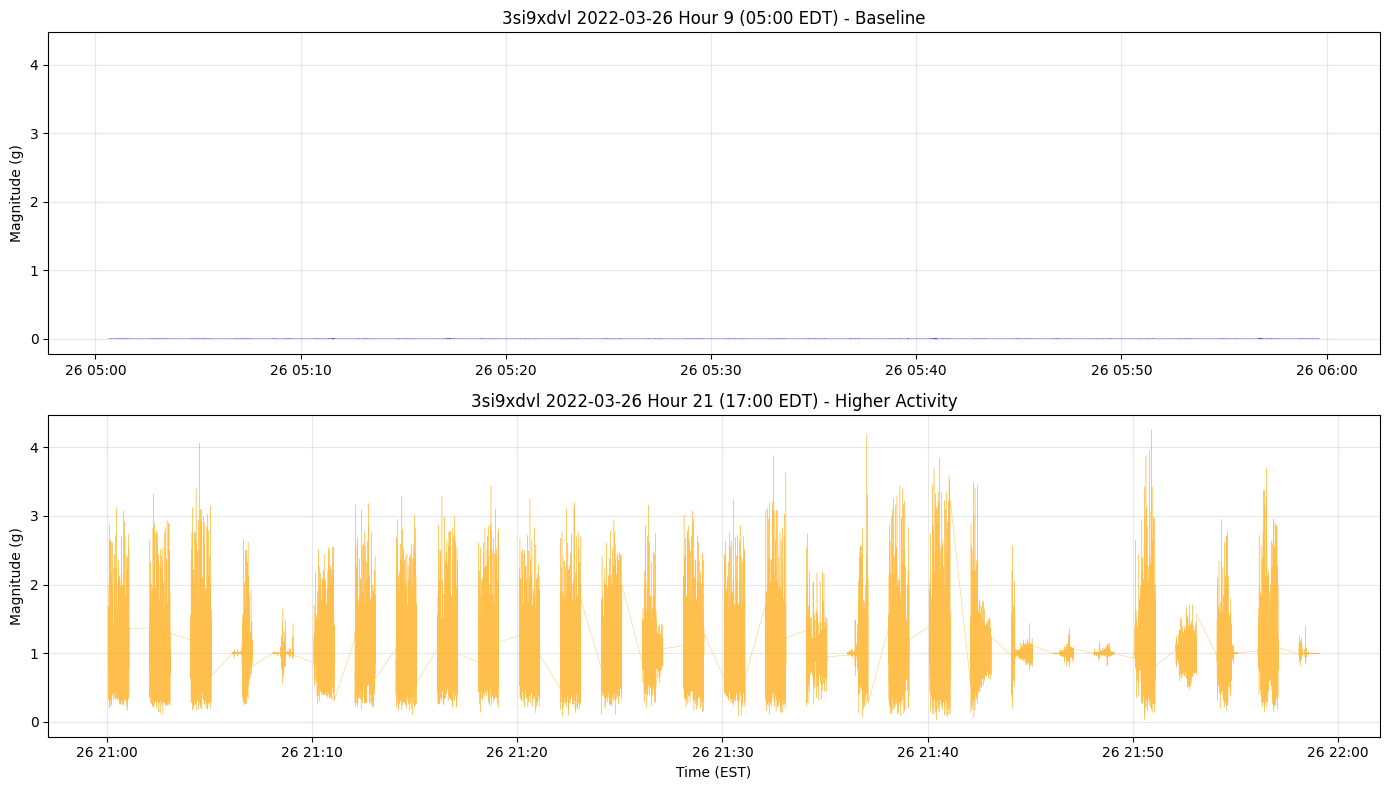

In [25]:
# Get summary stats for both hours
file_path_9 = base_path + "2022-03-26 09_00_00+00_00.csv"
df_9 = pd.read_csv(file_path_9)
df_9['datetime_est'] = pd.to_datetime(df_9['timestamp'], unit='ms', utc=True)
df_9['datetime_est'] = df_9['datetime_est'].dt.tz_convert('US/Eastern')
df_9['magnitude'] = np.sqrt(df_9['x']**2 + df_9['y']**2 + df_9['z']**2) - 1.0

print(f"\nHour 9 (baseline) magnitude statistics:")
print(f"  Min:  {df_9['magnitude'].min():.4f}")
print(f"  Max:  {df_9['magnitude'].max():.4f}")
print(f"  Mean: {df_9['magnitude'].mean():.4f}")
print(f"  Std:  {df_9['magnitude'].std():.4f}")

file_path_21 = base_path + "2022-03-26 21_00_00+00_00.csv"
df_21 = pd.read_csv(file_path_21)
df_21['datetime_est'] = pd.to_datetime(df_21['timestamp'], unit='ms', utc=True)
df_21['magnitude'] = np.sqrt(df_21['x']**2 + df_21['y']**2 + df_21['z']**2)

print(f"Hour 21 (active) magnitude statistics:")
print(f"  Min:  {df_21['magnitude'].min():.4f}")
print(f"  Max:  {df_21['magnitude'].max():.4f}")
print(f"  Mean: {df_21['magnitude'].mean():.4f}")
print(f"  Std:  {df_21['magnitude'].std():.4f}")

# set y axis limits
min_mag = min(df_9['magnitude'].min(), df_21['magnitude'].min())
max_mag = max(df_9['magnitude'].max(), df_21['magnitude'].max())
# add padding
y_padding = (max_mag - min_mag) * 0.05
y_min = min_mag - y_padding
y_max = max_mag + y_padding

fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=False)

# Hour 9
axes[0].plot(df_9['datetime_est'], df_9['magnitude'], linewidth=0.3, alpha=0.7, color='blue')
axes[0].set_ylabel('Magnitude (g)')
axes[0].set_title('3si9xdvl 2022-03-26 Hour 9 (05:00 EDT) - Baseline')
axes[0].set_ylim(y_min, y_max)
axes[0].grid(alpha=0.3)

# Hour 21 
axes[1].plot(df_21['datetime_est'], df_21['magnitude'], linewidth=0.3, alpha=0.7, color='orange')
axes[1].set_xlabel('Time (EST)')
axes[1].set_ylabel('Magnitude (g)')
axes[1].set_title('3si9xdvl 2022-03-26 Hour 21 (17:00 EDT) - Higher Activity')
axes[1].set_ylim(y_min, y_max)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

Some observations: 
- SD in acc. magnitude for hour 21 is 0.4605g and that of hour 9 is 0.0006, meaning there's ~800-fold change between hour 9 and hour 21. This confirms that the subject was active at hour 21.
- In hour 21, we can still see the minute-on, minute-off sampling patterns. 

In [18]:
# TODO move to script
def classify_activity(magnitude_series):
    """
    Simple activity classifier based on magnitude variation.
    """
    std = magnitude_series.std()
    
    if std < 0.01:
        return "Stationary"
    elif std < 0.1:
        return "Light movement"
    elif std < 0.3:
        return "Moderate activity"
    else:
        return "High activity"

In [19]:
# Also check other hours with higher mean magnitude to detect possible activity
higher_hrs = [5, 16, 19, 21]

print("=== Higher hours stats ===")
for hour in higher_hrs:
    file_path = base_path + f"2022-03-26 {hour:02d}_00_00+00_00.csv"
    df_temp = pd.read_csv(file_path)
    df_temp['magnitude'] = np.sqrt(df_temp['x']**2 + df_temp['y']**2 + df_temp['z']**2)
    
    print(f"Hour {hour:02d} ({(hour-4)%24:02d}:00 EDT):")
    print(f"  Mean: {df_temp['magnitude'].mean():.4f} g")
    print(f"  Std:  {df_temp['magnitude'].std():.4f} g")

=== Higher hours stats ===
Hour 05 (01:00 EDT):
  Mean: 1.0270 g
  Std:  0.1722 g
Hour 16 (12:00 EDT):
  Mean: 1.0340 g
  Std:  0.2509 g
Hour 19 (15:00 EDT):
  Mean: 1.0240 g
  Std:  0.2533 g
Hour 21 (17:00 EDT):
  Mean: 1.0891 g
  Std:  0.4605 g


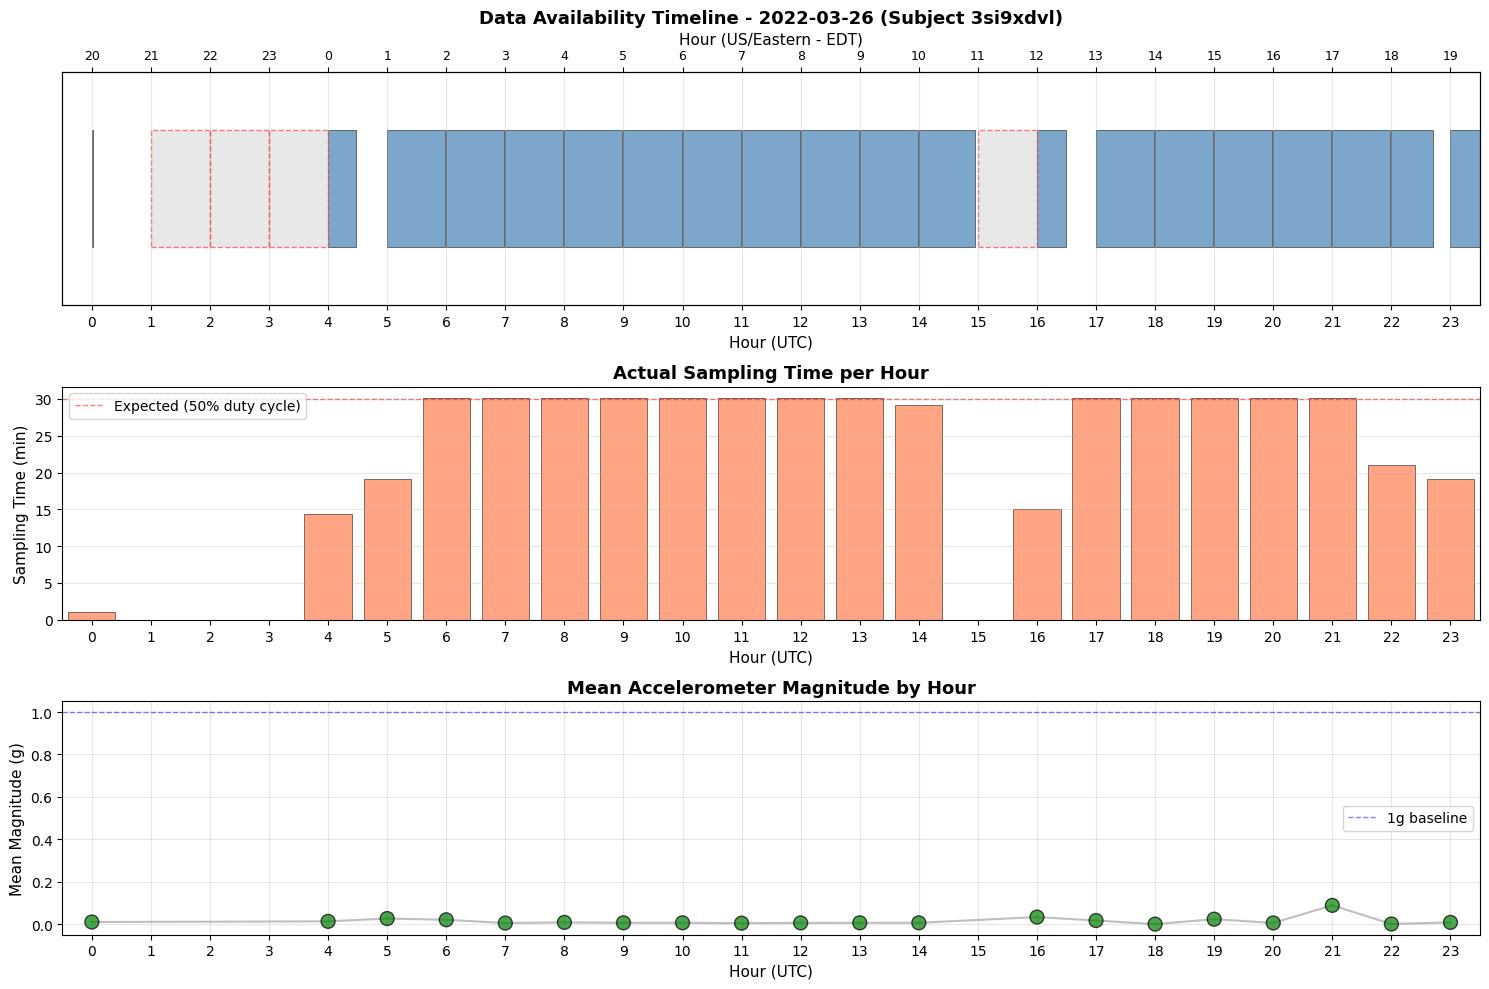

In [20]:
fig, axes = plt.subplots(3, 1, figsize=(15, 10))

# Data existence by hour
ax = axes[0]

for _, row in summary_df.iterrows():
    ax.barh(y=0, width=row['duration_min']/60, left=row['hour'], 
            height=0.5, color='steelblue', alpha=0.7, edgecolor='black', linewidth=0.5)

# Mark missing hours
all_hours = set(range(24))
present_hours = set(summary_df['hour'].values)
missing_hours = sorted(all_hours - present_hours)

for h in missing_hours:
    ax.barh(y=0, width=1, left=h, height=0.5, color='lightgray', 
            alpha=0.5, edgecolor='red', linewidth=1, linestyle='--')

ax.set_xlim(-0.5, 23.5)
ax.set_ylim(-0.5, 0.5)
ax.set_xlabel('Hour (UTC)', fontsize=11)
ax.set_title('Data Availability Timeline - 2022-03-26 (Subject 3si9xdvl)', 
             fontsize=13, fontweight='bold')
ax.set_yticks([])
ax.set_xticks(range(24))
ax.grid(axis='x', alpha=0.3)

# Eastern time on top
# TODO convert all to EDT
ax2 = ax.twiny()
ax2.set_xlim(-0.5, 23.5)
ax2.set_xticks(range(24))
ax2.set_xticklabels([(h-4)%24 for h in range(24)], fontsize=9)
ax2.set_xlabel('Hour (US/Eastern - EDT)', fontsize=11)

# Actual sampling time  
ax = axes[1]

ax.bar(summary_df['hour'], summary_df['sampling_min'], 
       color='coral', alpha=0.7, edgecolor='black', linewidth=0.5, width=0.8)
ax.set_xlim(-0.5, 23.5)
ax.set_xlabel('Hour (UTC)', fontsize=11)
ax.set_ylabel('Sampling Time (min)', fontsize=11)
ax.set_title('Actual Sampling Time per Hour', fontsize=13, fontweight='bold')
ax.axhline(y=30, color='red', linestyle='--', linewidth=1, alpha=0.5, 
           label='Expected (50% duty cycle)')
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_xticks(range(24))

# Mean Magnitude
ax = axes[2]

colors = ['red' if mag > 1.05 else 'green' for mag in summary_df['mean_magnitude']]
ax.scatter(summary_df['hour'], summary_df['mean_magnitude'], 
          s=100, c=colors, alpha=0.7, edgecolor='black', linewidth=1, zorder=3)
ax.plot(summary_df['hour'], summary_df['mean_magnitude'], 
        linewidth=1.5, color='gray', alpha=0.5, zorder=2)

# TODO add mild, moderate, high activity colors and legend
ax.set_xlim(-0.5, 23.5)
ax.set_xlabel('Hour (UTC)', fontsize=11)
ax.set_ylabel('Mean Magnitude (g)', fontsize=11)
ax.set_title('Mean Accelerometer Magnitude by Hour', fontsize=13, fontweight='bold')
ax.axhline(y=1.0, color='blue', linestyle='--', linewidth=1, alpha=0.5, label='1g baseline')
ax.legend()
ax.grid(alpha=0.3)
ax.set_xticks(range(24))
# TODO install jupyter specific version control package

plt.tight_layout()
plt.show()

## Bookmark 25-10-10 
### TODO: 
#  - Take care of TODOs in the cell
#  - Read in data from multiple days and subjects (with EDT column and data present indicator), save as intermediate results
# - mini goal: Visualize indicators at the hourly, daily, and weekly level for fixed subject

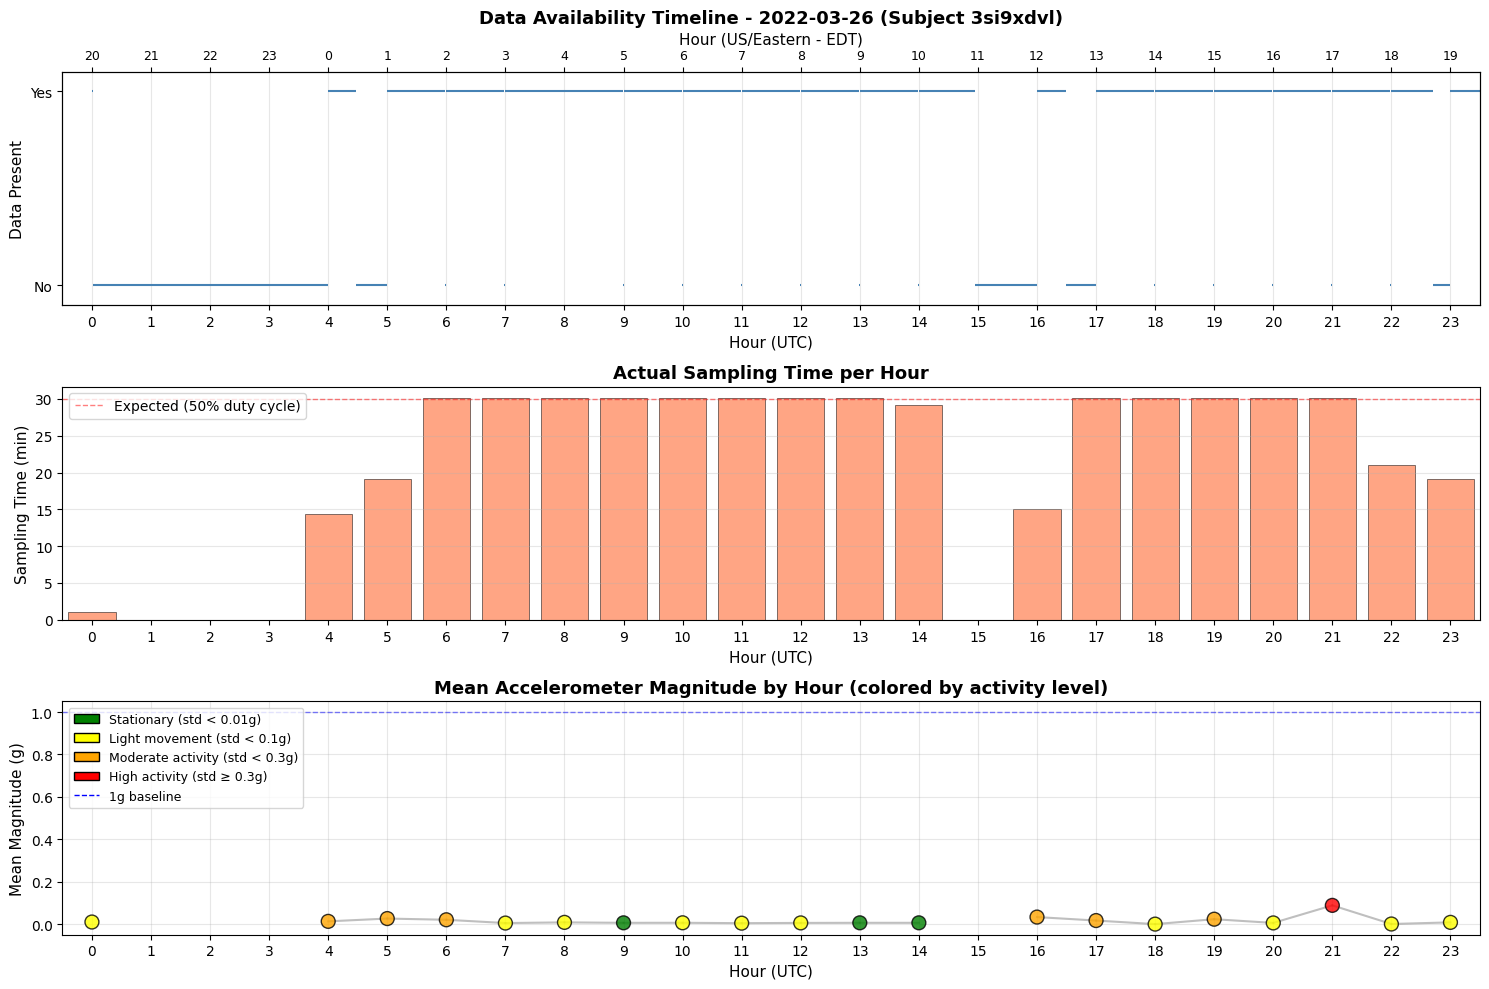

In [21]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import numpy as np

# Recalculate to include std
daily_summary_enhanced = []

for hour in range(24):
    file_name = f"{date_str} {hour:02d}_00_00+00_00.csv"
    file_path = base_path + file_name
    
    result = summarize_hourly_file(file_path, verbose=False)
    
    if result is not None:
        # Load file again to calculate std
        df_temp = pd.read_csv(file_path)
        df_temp['magnitude'] = np.sqrt(df_temp['x']**2 + df_temp['y']**2 + df_temp['z']**2)
        
        result['hour'] = hour
        result['date'] = date_str
        result['subject_id'] = subject_id
        result['std_magnitude'] = df_temp['magnitude'].std()  # Add std
        daily_summary_enhanced.append(result)

summary_df = pd.DataFrame(daily_summary_enhanced)

# Create the plot
fig, axes = plt.subplots(3, 1, figsize=(15, 10))

# === PLOT 1: Data Availability with horizontal lines at y=0 and y=1 ===
ax = axes[0]

# Group consecutive hours to form segments for both present and missing data
present_segments = []
missing_segments = []
current_segment = []

# First find segments where data is present
sorted_data = summary_df.sort_values('hour')
for idx, row in sorted_data.iterrows():
    hour_start = row['hour']
    hour_end = row['hour'] + row['duration_min'] / 60
    
    if not current_segment:
        current_segment = [hour_start, hour_end]
    elif hour_start <= current_segment[1]:
        current_segment[1] = max(current_segment[1], hour_end)
    else:
        present_segments.append(current_segment)
        current_segment = [hour_start, hour_end]
        
if current_segment:
    present_segments.append(current_segment)

# Find missing segments by looking at gaps between present segments
all_segments = []
if present_segments:
    # Add segment from 0 to first present segment if needed
    if present_segments[0][0] > 0:
        missing_segments.append([0, present_segments[0][0]])
    
    # Add segments between present segments
    for i in range(len(present_segments)-1):
        missing_segments.append([present_segments[i][1], present_segments[i+1][0]])
    
    # Add segment from last present segment to 24 if needed
    if present_segments[-1][1] < 24:
        missing_segments.append([present_segments[-1][1], 24])

# Plot horizontal lines for present data (y=1)
for segment in present_segments:
    ax.hlines(y=1, xmin=segment[0], xmax=segment[1], 
              color='steelblue', linewidth=1.5)

# Plot horizontal lines for missing data (y=0)
for segment in missing_segments:
    ax.hlines(y=0, xmin=segment[0], xmax=segment[1], 
              color='steelblue', linewidth=1.5)

ax.set_xlim(-0.5, 23.5)
ax.set_ylim(-0.1, 1.1)
ax.set_xlabel('Hour (UTC)', fontsize=11)
ax.set_ylabel('Data Present', fontsize=11)
ax.set_title('Data Availability Timeline - 2022-03-26 (Subject 3si9xdvl)', 
             fontsize=13, fontweight='bold')
ax.set_yticks([0, 1])
ax.set_yticklabels(['No', 'Yes'])
ax.set_xticks(range(24))
ax.grid(axis='x', alpha=0.3)

# Plot 1 step function style with connecting vertical lines 
# ax = axes[0]

# # Initialize lists for step function
# hours = []
# values = []

# # Create step function for data presence
# for _, row in summary_df.iterrows():
#     hour_start = row['hour']
#     hour_end = row['hour'] + row['duration_min'] / 60  # Fractional hour
    
#     # Add points for step function
#     if len(hours) == 0 or hour_start > hours[-1]:
#         # Add point to drop to 0 before new segment starts
#         hours.append(hour_start)
#         values.append(0)
    
#     # Add points for this hour's data
#     hours.extend([hour_start, hour_end])
#     values.extend([1, 1])
    
#     # Add final drop to 0 after segment
#     hours.append(hour_end)
#     values.append(0)

# # Plot step function
# ax.plot(hours, values, color='steelblue', linewidth=1.5, drawstyle='steps')

# Mark missing hours with red dashed boxes
# all_hours = set(range(24))
# present_hours = set(summary_df['hour'].values)
# missing_hours = sorted(all_hours - present_hours)

# for h in missing_hours:
#     ax.add_patch(mpatches.Rectangle((h, 0), 1, 1, 
#                                    fill=False, edgecolor='red', 
#                                    linestyle='--', linewidth=1.5))

ax.set_xlim(-0.5, 23.5)
ax.set_ylim(-0.1, 1.1)
ax.set_xlabel('Hour (UTC)', fontsize=11)
ax.set_ylabel('Data Present', fontsize=11)
ax.set_title('Data Availability Timeline - 2022-03-26 (Subject 3si9xdvl)', 
             fontsize=13, fontweight='bold')
ax.set_yticks([0, 1])
ax.set_yticklabels(['No', 'Yes'])
ax.set_xticks(range(24))
ax.grid(axis='x', alpha=0.3)

# Eastern time on top
ax2 = ax.twiny()
ax2.set_xlim(-0.5, 23.5)
ax2.set_xticks(range(24))
ax2.set_xticklabels([(h-4)%24 for h in range(24)], fontsize=9)
ax2.set_xlabel('Hour (US/Eastern - EDT)', fontsize=11)

# === Sampling Time ===
ax = axes[1]

ax.bar(summary_df['hour'], summary_df['sampling_min'], 
       color='coral', alpha=0.7, edgecolor='black', linewidth=0.5, width=0.8)
ax.set_xlim(-0.5, 23.5)
ax.set_xlabel('Hour (UTC)', fontsize=11)
ax.set_ylabel('Sampling Time (min)', fontsize=11)
ax.set_title('Actual Sampling Time per Hour', fontsize=13, fontweight='bold')
ax.axhline(y=30, color='red', linestyle='--', linewidth=1, alpha=0.5, 
           label='Expected (50% duty cycle)')
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_xticks(range(24))

# --- PLOT 3: Mean Magnitude with Activity Classification ---
ax = axes[2]

# Classify by std and assign colors
def get_color_by_std(std):
    if std < 0.01:
        return 'green'
    elif std < 0.1:
        return 'yellow'
    elif std < 0.3:
        return 'orange'
    else:
        return 'red'

colors = [get_color_by_std(std) for std in summary_df['std_magnitude']]

# Plot points
ax.scatter(summary_df['hour'], summary_df['mean_magnitude'], 
          s=100, c=colors, alpha=0.8, edgecolor='black', linewidth=1, zorder=3)

# Draw connecting lines only between consecutive hours
summary_df_sorted = summary_df.sort_values('hour')
hours = summary_df_sorted['hour'].values
magnitudes = summary_df_sorted['mean_magnitude'].values

for i in range(len(hours) - 1):
    current_hour = hours[i]
    next_hour = hours[i + 1]
    
    # Only connect if hours are consecutive (differ by 1)
    if next_hour - current_hour == 1:
        ax.plot([current_hour, next_hour], 
                [magnitudes[i], magnitudes[i + 1]], 
                linewidth=1.5, color='gray', alpha=0.5, zorder=2)

ax.set_xlim(-0.5, 23.5)
ax.set_xlabel('Hour (UTC)', fontsize=11)
ax.set_ylabel('Mean Magnitude (g)', fontsize=11)
ax.set_title('Mean Accelerometer Magnitude by Hour (colored by activity level)', 
             fontsize=13, fontweight='bold')
ax.axhline(y=1.0, color='blue', linestyle='--', linewidth=1, alpha=0.5, 
           label='1g baseline')

# Create legend for activity levels
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='green', edgecolor='black', label='Stationary (std < 0.01g)'),
    Patch(facecolor='yellow', edgecolor='black', label='Light movement (std < 0.1g)'),
    Patch(facecolor='orange', edgecolor='black', label='Moderate activity (std < 0.3g)'),
    Patch(facecolor='red', edgecolor='black', label='High activity (std ≥ 0.3g)'),
    Line2D([], [], color='blue', linestyle='--', linewidth=1, 
                    label='1g baseline')
]
ax.legend(handles=legend_elements, loc='upper left', fontsize=9)
ax.grid(alpha=0.3)
ax.set_xticks(range(24))

plt.tight_layout()
plt.show()

In [22]:
summary_df.columns

Index(['n_rows', 'start_time', 'end_time', 'duration_min', 'sampling_min',
       'duty_cycle', 'n_bursts', 'mean_magnitude', 'hour', 'date',
       'subject_id', 'std_magnitude'],
      dtype='object')